In [94]:
import pandas as pd
import numpy as np

import pickle
import importlib

import matplotlib.pyplot as plt
import japanize_matplotlib

In [95]:
import common

# モジュールの再読み込み
importlib.reload(common)

_common = common.Common()
_common.BASE_PATH

PosixPath('/Users/iwasakitakahiro/github')

In [96]:
train_df = pd.read_csv('../output/中間データ/学習用データ/train_preprocessed.csv')
test_df = pd.read_csv('../output/中間データ/評価用データ/test_preprocessed.csv')

In [97]:
train_tail = train_df.tail(35)

# --- test_dfの先頭に連結 ---
test_df = pd.concat([train_tail, test_df], ignore_index=True)

In [98]:
def build_model1_dataset(df, is_test=False):
    df = df.copy()
    df[_common.UNIQUE_KEY_COLS] = pd.to_datetime(df[_common.UNIQUE_KEY_COLS])
    records = []

    for day in pd.date_range(df[_common.UNIQUE_KEY_COLS].min() + pd.Timedelta(days=2),
                             df[_common.UNIQUE_KEY_COLS].max(), freq='D'):
        day_start = day.replace(hour=0)
        day_end = day.replace(hour=23)
        day_times = pd.date_range(day_start, day_end, freq='h')

        feature_end = day - pd.Timedelta(hours=12)  # 前日12時
        feature_start = feature_end - pd.Timedelta(hours=23)  # 前々日13時
        feature_times = pd.date_range(feature_start, feature_end, freq='h')

        x = df[df[_common.UNIQUE_KEY_COLS].isin(feature_times)].copy()
        y = df[df[_common.UNIQUE_KEY_COLS].isin(day_times)].copy() if not is_test else None

        if len(x) == 24 and (is_test or len(y) == 24):
            # 除外カラムの設定
            drop_cols = [_common.UNIQUE_KEY_COLS]
            if 'price_actual' in x.columns:
                drop_cols.append('price_actual')
            if not is_test and _common.TARGET_COL in x.columns:
                drop_cols.append(_common.TARGET_COL)

            # 特徴量の集約（平均）
            x_agg = x.drop(columns=drop_cols, errors='ignore').mean().to_dict()
            x_agg['day'] = day.date()

            for t in day_times:
                row = x_agg.copy()
                row['forecast_hour'] = t.hour
                row['target_time'] = t
                if not is_test:
                    row['target_price'] = y.loc[y[_common.UNIQUE_KEY_COLS] == t, _common.TARGET_COL].values[0]
                records.append(row)

    return pd.DataFrame(records)

In [99]:
df_model1_test = build_model1_dataset(test_df, is_test=True)

In [100]:
features_model1 = [col for col in df_model1_test.columns if col not in ['day', 'forecast_hour', 'target_time', 'target_price']]
X_model1_test = df_model1_test[features_model1]

In [101]:
with open('../output/モデル/sep_model1_lgb.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
model1 = loaded_model['model']

y_pred_lgb = model1.predict(X_model1_test)

In [102]:
df_model1_test['price_day_ahead_pred'] = model1.predict(X_model1_test)

In [103]:
def build_model2_dataset(df, model1_pred_df, is_test=False):
    df = df.copy()
    df[_common.UNIQUE_KEY_COLS] = pd.to_datetime(df[_common.UNIQUE_KEY_COLS])
    model1_pred_df = model1_pred_df.copy()

    records = []

    for _, row in model1_pred_df.iterrows():
        target_time = row['target_time']

        # 柔軟な系列長（前日13時から target_time の1時間前まで）
        feature_start = (target_time - pd.Timedelta(days=1)).replace(hour=13, minute=0)
        feature_end = target_time - pd.Timedelta(hours=1)
        feature_times = pd.date_range(feature_start, feature_end, freq='h')

        x = df[df[_common.UNIQUE_KEY_COLS].isin(feature_times)].copy()
        if len(x) != len(feature_times):
            continue

        drop_cols = [_common.UNIQUE_KEY_COLS]
        if 'price_actual' in x.columns:
            drop_cols.append('price_actual')
        if not is_test and _common.TARGET_COL in x.columns:
            drop_cols.append(_common.TARGET_COL)

        x_agg = x.drop(columns=drop_cols, errors='ignore').mean().to_dict()
        x_agg['target_time'] = target_time
        x_agg['price_day_ahead_pred'] = row['price_day_ahead_pred']

        if not is_test and 'target_price' in row:
            x_agg['target_price'] = row['target_price']

        records.append(x_agg)

    return pd.DataFrame(records)

In [104]:
df_model2_test = build_model2_dataset(test_df, df_model1_test, is_test=True)

In [105]:
features_model2 = [col for col in df_model2_test.columns if col not in ['target_time', 'target_price']]
X_model2_test = df_model2_test[features_model2]

In [106]:
with open('../output/モデル/sep_model2_lgb.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
model2 = loaded_model['model']

y_pred_lgb = model2.predict(X_model2_test)

In [107]:
df_model2_test['price_final_pred'] = model2.predict(X_model2_test)

#### 予測結果の出力

In [108]:
result_df = pd.read_csv('../input/提出用データ/sample_submit.csv', header=None)

/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_15155/1275547945.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       36.144415
1       36.106656
2       42.846236
3       57.704943
4       61.514948
          ...    
8755    67.762041
8756    67.230658
8757    67.197152
8758    73.181953
8759    70.931363
Name: price_final_pred, Length: 8760, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result_df.iloc[:, 1] = df_model2_test['price_final_pred']
/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_15155/1275547945.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`

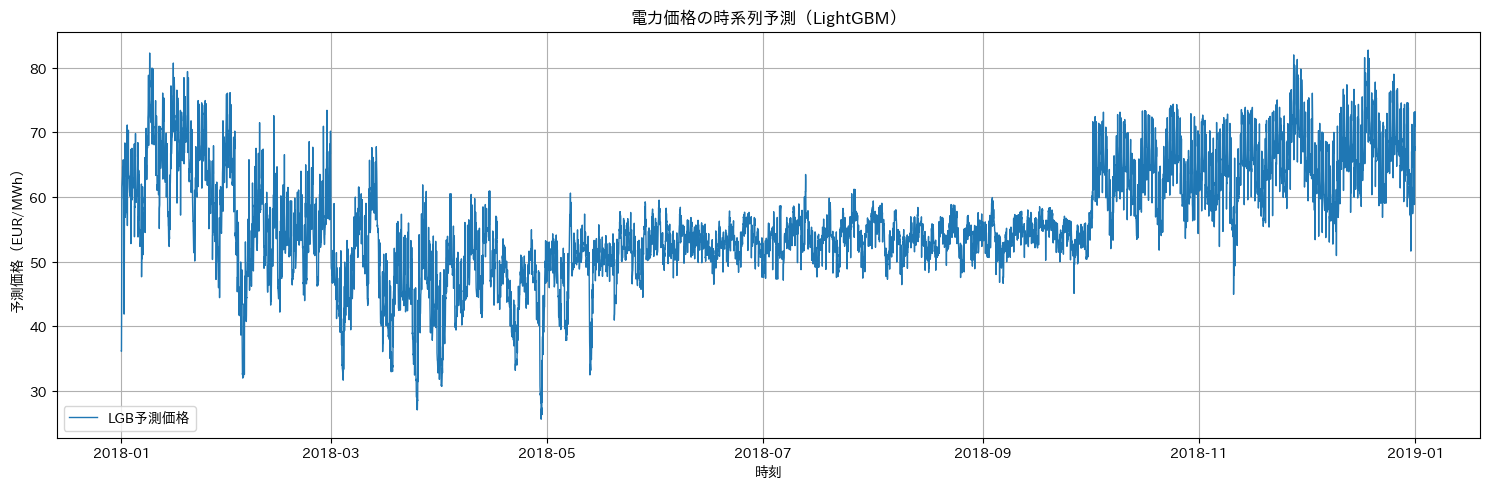

In [109]:
result_df.iloc[:, 1] = df_model2_test['price_final_pred']
result_df.to_csv('../output/予測結果/予測結果_2段階.csv', index=False)
result_df.head()

# time列をdatetime型に変換
result_df.iloc[:, 0] = pd.to_datetime(result_df.iloc[:, 0])

# プロット
plt.figure(figsize=(15, 5))
plt.plot(result_df.iloc[:, 0], result_df.iloc[:, 1], label='LGB予測価格', linewidth=1)

plt.xlabel('時刻')
plt.ylabel('予測価格（EUR/MWh）')
plt.title('電力価格の時系列予測（LightGBM）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()